# Movie Recommender Project Report 
<br>
<font size=4> Team members: </font> <br><br>
<font size=3> James Jungsuk Lee [UNI] </font><br>
<font size=3> Ujjwal Peshin [UNI]</font><br>
<font size=3> Bowen Zhou [UNI]</font><br>
<font size=3> Zhongling Jiang [UNI]</font>

In [2]:
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import random
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql import Window 
from pyspark.sql.functions import col, expr
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SQLContext

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

from surprise import AlgoBase
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise import KNNWithMeans
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
import pandas as pd
import random

import itertools
RANDOM_SPLIT_SEED = 24
TRAIN_PROPORTION = 0.9
TEST_PROPORTION = 1 - TRAIN_PROPORTION

### Answer to 
As data scientists of a digital media company, state your objectives in building a
recommendation system. For example, what metrics do you care about, who is this system
built to serve (users or your boss?), and what business rules may you care to introduce?

As a data scientist, you want to create a solution that serves the users but as well as can satisify your coworkers such as your boss. Having key stakeholders bought into your idea is integral in adding value to the company. So here we list out a few metrics and ideas that we can focus on and also point out who they serve.

Users: <br/>
We want our users to feel engaged with our content. That means we want to push out recommendations that they can relate to and enjoy. Within the context of our project, we can measure accuracy of our model such as RMSE. However, there can be some other things we can measure as well that's a bit out of scope of this project such as serendipity of our recommendations and implicit feedbacks such as how long they listen or watch our recommendations even if they don't explicitly rate them.
    
Stakeholders: <br/>
Stakeholders want to make sure that the solutions that we recommend are indeed better than what they can do or have done in the past. They also want to understand how this system is affecting the product that they own. This means that measurements such as accuracy is also useful for stakeholders, but we can additionally focus on model methods that help them interpret the model's output. This means using simpler methods such as KNN or exploring Matrix Factorization methods to see if there can be any patterns in a reduced dimension space that can make sense to human rationality.

## Part I: Data Preparation

**Description: ** <br><br>

### Create a smaller development set

In [3]:
spark = SparkSession.builder.appName('proj_1').getOrCreate()
ratings = spark.read.csv('gs://moviercommendation/ml-20m/ratings.csv', header = True, 
                         inferSchema=True).cache()
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [4]:
pd.DataFrame(ratings.take(5), columns=ratings.columns)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
random.seed(100)

In [6]:
def subsample(movies, n, p):
    """
    The function subsample the list of movies that each user rates, based on following rule:
    (i) If user has rated fewer than n movies, we keep all ratings
    (ii) If user has rated a lot of movies, we keep only p percent of them via random selection
    (iii) If number of movies * p percent is less than n, we randomly sample n movies and 
         keep these ratings
    """
    if len(movies) <= n:
        return movies
    elif int(p * len(movies)) <= n:
        return random.sample(movies, n)
    else:
        return random.sample(movies, int(p * len(movies)))
N = 5
P = 0.01    
# collect all movies each user has rated
ratings_rdd = ratings.select(['userId', 'movieId']).rdd.map(list)
users_rated_movies = ratings_rdd.groupByKey().mapValues(list)

# call subsample on rated movies
subsampled_users_rated_movies= users_rated_movies.mapValues(lambda m: subsample(m, N, P))

# Now convert these ratings back to dataframe
subsampled_ratings = subsampled_users_rated_movies.flatMapValues(lambda x: x)
subsampled_ratings = spark.createDataFrame(subsampled_ratings, ['userId', 'movieId'])

# check size of the subsampled dataset
subsample_rowcounts = subsampled_ratings.count()
subsample_percentage = subsample_rowcounts * 1.0 / ratings.count() * 100
print ('The subsampled dataset is {0}% size of the original dataset, has {1} rows'.\
       format(subsample_percentage, subsample_rowcounts))

The subsampled dataset is 3.58695283157% size of the original dataset, has 717400 rows


In [7]:
# Join them back to original dataset to get ratings and time stamps, using userId and movieId as key
subsampled_ratings = subsampled_ratings.join(ratings, ['userId','movieid'], 'inner')
subsampled_ratings.persist()
pd.DataFrame(subsampled_ratings.take(5), columns=subsampled_ratings.columns)

,userId,movieId,rating,timestamp
0,32,292,4.0,845962584
1,48,232,4.0,850710897
2,110,2683,0.5,1171080409
3,136,109487,5.0,1415634668
4,173,2054,1.0,1146331973


### Divide into training, validation and test set <br>

**Description**: <br><br>


**Output**: 'train' - training set,  'val' - validation set, 'test' - test set

In [8]:
subsampled_ratings = subsampled_ratings.withColumn("timestamp", ratings["timestamp"].cast(T.TimestampType()))
subsampled_ratings.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [9]:
limit = 10
# test size
test_size = 0.05
def udf_user_limit(user_counts):
    if user_counts < limit:
        return -1
    else:
        if (user_counts * (1-test_size)) <= limit:
            return limit
        else:
            return int(np.around(user_counts * (1-test_size)))
user_limit = F.udf(udf_user_limit, T.IntegerType())

In [10]:
# train-test function
def train_test_split(data, col_to_split_on= 'userId', timestamp_col = 'timestamp'):
    # original columns
    orig_cols = data.columns
    # define count col
    count_col = 'count(' + col_to_split_on + ')'
    # do user ratings count
    counts_for_col = data.groupby(col_to_split_on).agg(F.count(col_to_split_on))
    # generate limits on each user based on rules
    limits = counts_for_col.withColumn('train_limit', user_limit(F.col(count_col)))
    # remove users having less than limit no of ratings
    limits_filtered = limits.filter(limits.train_limit > 0)
    # generate row numbers based on temporality
    data_row_num = data.withColumn("row_num", F.row_number().over(Window.partitionBy(col_to_split_on).orderBy(timestamp_col)))
    # join ratings and user counts dfs together
    data_row_num = data_row_num.alias('a')
    limits_filtered = limits_filtered.alias('b')
    merged_data = data_row_num.join(limits_filtered,F.col('b.' + col_to_split_on) == F.col('a.' + col_to_split_on)).select([F.col('a.'+xx) for xx in data_row_num.columns] + [F.col('b.' + count_col),F.col('b.train_limit')])
    # generate selection column based on number limit
    final_train_test = merged_data.withColumn('selection', F.col('row_num') <= F.col('train_limit'))
    # find train and test 
    train = final_train_test.filter(final_train_test.selection == True).select(orig_cols)
    test = final_train_test.filter(final_train_test.selection == False).select(orig_cols)
    return train, test

In [11]:
# to check if test has more entities in any column
def compatibility_test(train, test, cols_to_test = ['userId', 'movieId']):
    cols_greater = []
    for i in cols_to_test:
        train_unique = train.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
        test_unique = test.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
        size = len(list(set(test_unique) - set(train_unique)))
        print("Test has %d more %s" %(size, i))
        cols_greater.append(i)
    return cols_greater

In [12]:
traincv, test = train_test_split(subsampled_ratings, col_to_split_on= 'movieId', timestamp_col='timestamp')
print((traincv.count(), len(traincv.columns)))
print((test.count(), len(test.columns)))
cols_greater = compatibility_test(traincv, test, cols_to_test=['userId', 'movieId'])

(661090, 4)
(34963, 4)
Test has 1368 more userId
Test has 0 more movieId


In [13]:
for i in cols_greater:
    traincv_unique = traincv.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
    test_unique = test.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
    unique_to_test = list(set(test_unique) - set(traincv_unique))
    test = test[~test[i].isin(unique_to_test)]
# After removing users/ movies not included in training set
print((traincv.count(), len(traincv.columns)))
print((test.count(), len(test.columns)))
cols_greater = compatibility_test(traincv, test, cols_to_test=['userId', 'movieId'])
test.persist()

(661090, 4)
(28500, 4)
Test has 0 more userId
Test has 0 more movieId


DataFrame[userId: bigint, movieId: bigint, rating: double, timestamp: timestamp]

Repeat the same logic on train / validation set split

In [14]:
train, val = train_test_split(traincv, col_to_split_on= 'movieId', timestamp_col='timestamp')
print((train.count(), len(train.columns)))
print((val.count(), len(val.columns)))
cols_greater = compatibility_test(train, val, cols_to_test=['userId', 'movieId'])

(628065, 4)
(33025, 4)
Test has 2149 more userId
Test has 0 more movieId


In [15]:
for i in cols_greater:
    train_unique = train.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
    val_unique = val.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
    unique_to_val = list(set(val_unique) - set(train_unique))
    val = val[~val[i].isin(unique_to_val)]
print((train.count(), len(train.columns)))
print((val.count(), len(val.columns)))
cols_greater = compatibility_test(train, val, cols_to_test=['userId', 'movieId'])
train.persist()
val.persist()

(628065, 4)
(28821, 4)
Test has 0 more userId
Test has 0 more movieId


DataFrame[userId: bigint, movieId: bigint, rating: double, timestamp: timestamp]

In [127]:
# train.write.csv('gs://moviercommendation/train.csv')
# val.write.csv('gs://moviercommendation/val.csv')
# test.write.csv('gs://moviercommendation/test.csv')

### Evaluation Metrics

We explored mainly two type of evaluation metrics on our recommender system -- regression metrics and ranking metrics.
The problem setting can be described as the following: 

Assume U is a set of M users, $U=\{u_0,u_1,...,u_{M−1}\}$. 

Each user $u_i$ having a set of N ground truth relevant movies $D_i=\{d_0,d_1,...,d_{N−1}\}$ and a list of Q recommended movies, in order of decreasing relevance $Ri=\{r_0,r_1,...,r_{Q−1}\}$

Our goal is to evaluate how relevant our recommended movies are for each user. The relevance of the sets and the effectiveness of the algorithms can be measured using the metrics listed below.

Before diving into definition of metrics, we define a indicator function which, provided a recommended document and a set of ground truth relevant documents, returns a 0/1 score to indicate relevance.

$rel_D(r)$ = \begin{cases}
    1,& \text{if } r\in D\\
    0,              & \text{otherwise}
\end{cases}


#### I. Regression Metric

* Root Mean Square Error (RMSE): $\frac{\sqrt{\sum_{i=0}^{N - 1}e_{i}^2}}{N}$
* Mean Absolute Error (MAE): $\frac{\sum_{i=0}^{N - 1}|e_{i}|}{N}$
* R-squared: $1 - \frac{\sum_{i=0}^{N - 1} (e_i)^2 }{\sum_{i=0}^{N - 1} (y_i - \bar{y}_i)^2}$
* Explained Variance: $1 - \frac{Var(y - \hat{y})}{Var(y)} $

In [19]:
def regression_metric(ratings, predicted_ratings):
    """
        Calculate regression metrics
        - root mean square error
        - mean absoluate error
        - r squared
        - explained variance
        by joining original and predicted rating dataset into 
        ((userId, movieId), (original_rating, predicted_rating)).
        :ratings: original rating dataset. Format:   userId | movieId | rating
        :predicted_ratings: predicted rating dataset
    """
    ratings_tuple = ratings.rdd.map(lambda r: ((r.userId, r.movieId), r.rating))
    predicted_ratings_tuple = predicted_ratings.rdd.map(lambda r: ((r.userId, r.movieId), r.rating))
    score_and_labels = predicted_ratings_tuple.join(ratings_tuple).map(lambda tup: tup[1])
    metrics = RegressionMetrics(score_and_labels)
    print("RMSE = %s" % metrics.rootMeanSquaredError)
    print("MAE = %s" % metrics.meanAbsoluteError)
    print("R-squared = %s" % metrics.r2)
    print("Explained Variance = %s" % metrics.explainedVariance)
    return metrics.rootMeanSquaredError, metrics.meanAbsoluteError, metrics.r2, metrics.explainedVariance

#### II. Ranking Metric

* Precision @ k: measures on average what proportion of first k recommended movies to users are contained in true set of relevant movies to each user, i.e.<br>

<font size=2.5>$p(k) = \frac{1}{M}\sum_{i=0}^{M-1}\frac{1}{k}\sum_{j=0}^{min(|D|, k)-1}rel_{D_i}(R_i(j))$</font>

* Mean Average Precision @ k: measures similar quantity as Precision @ k except imposing penalty regarding order of recommendation, i.e. <br>

<font size=2.5>$p(k) = \frac{1}{M}\sum_{i=0}^{M-1}\frac{1}{k}\sum_{j=0}^{min(|D|, k)-1}\frac{rel_{D_i}(R_i(j))}{j + 1}$</font>

* Normalized Discounted Continuous Gain (NDCG): measures how many of the first k recommended moveis are in the set of true relevant documents averaged across all users, while taking into account the order of the recommendations (movies are assumed to be in order of decreasing relevance).

<font size=2.5>$NDCG(k) = \frac{1}{M}\sum_{i=0}^{M-1} \frac{1}{IDCG(D_i, k)}\sum_{j=0}^{n-1}\frac{rel_{D_i}(R_i(j))}{ln(j + 1)} $<font> <br>
where $IDCG(k) = \sum_{j=0}^{min(|D|, k)-1}\frac{rel_{D_i}(R_i(j))}{ln(j + 1)}$ represents best possible attained by the most ideal ranking.
    
**Procedure**:

(i) Filter out movies with rating score < r, because we are only interested in evaluating relevant movies, or 'good' recommendations. 

(ii) Sort ground truths and predictions by ratings (predicted ratings) and retrieve top k movies as reccommended items for a user. If in test set, a user rates fewer than k movies, then only retrieve all his rated movies.


(iii) Calculate specific ranking metric on test set and predicted set.

In [20]:
# Ranking metrics
# https://vinta.ws/code/spark-ml-cookbook-pyspark.html
def ranking_metric(ratings, predicted_ratings, r=3, k=5):
    """
        Calculate ranking metrics
        - mean average precision
        - precision at k
        - normalized discounted continuous gain at k
        by collecting recommended items and then comparing them to relevant groud truth items, 
        which takes form of
        ((userId, movieId), ([[predicted_item1, predicted_item2, ...], [item1, item2, ...]))
        :ratings: original rating dataset. Format:   userId | movieId | rating
        :predicted ratings: predicted rating dataset, same format
        :r: threshold for rating that defines a 'relevant' movie
        :k: top k positions used for comparison
    """
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    perUserPredictedItemsDF = predicted_ratings \
        .where('rating >= {0}'.format(r)) \
        .select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
        .where('rank <= {0}'.format(k)) \
        .groupBy('userId') \
        .agg(expr('collect_list(movieId) as itemsId'))
    
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    perUserActualItemsDF = ratings \
        .where('rating >= {0}'.format(r)) \
        .select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
        .where('rank <= {0}'.format(k)) \
        .groupBy('userId') \
        .agg(expr('collect_list(movieId) as itemsId')) 
    
    perUserItemsRDD = perUserPredictedItemsDF.join(perUserActualItemsDF, 'userId') \
        .rdd \
        .map(lambda row: (row[1], row[2]))
    rankingMetrics = RankingMetrics(perUserItemsRDD)

    print("mean Average Precision = %s" %rankingMetrics.meanAveragePrecision)
    print("Precision at k = %s" %rankingMetrics.precisionAt(k))
    print("NDCG at k = %s" %rankingMetrics.ndcgAt(k))  
    
    return rankingMetrics.meanAveragePrecision, rankingMetrics.precisionAt(k), rankingMetrics.ndcgAt(k)

#### III. Coverage

Define $r :=$ threshold for a ‘good’ movie for a user.   <br>
$k:=$ the number of movies that system recommends well.  <br>

**User Coverage** measures the proportion of users that our system can at least recommend k movies well. The criteria of a movie being recommended well is its ground-truth rating >= r. For each user, rank movies by their predicted ratings and see if there are at least k good recommendations. If there are, label the user as a successful recommender case. The metric calculates the percentage of such successful cases.<br>

**Item Coverage** measures the proportion of movies that are at least recommended to k users. It measures similar quantity but for movies.<br>

**Catalog Coverage** measures the proportions of all movies are recommended to users. This is calculated by collecting movies contained among top-k recommendations for all users, after excluding movies that either < r predicted ratings or actual ratings. The metric measures how many movies that the system is able to cover.


In [205]:
def user_coverage_metric(ratings, predicted_ratings, r=3, k=5):
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    perUserPredictedItemsDF = predicted_ratings \
        .where('rating >= {0}'.format(r)) \
        .select(col('userId').alias('p_userId'), col('movieId').alias('p_movieId'), \
                F.col('rating').alias('p_ratings'), F.rank().over(windowSpec).alias('rank'))  
    # join with test set ratings and rename columns
    joined = perUserPredictedItemsDF \
        .join(val, (perUserPredictedItemsDF.p_userId ==val.userId) & \
              (perUserPredictedItemsDF.p_movieId == val.movieId))     
    # the number of users have above threshold, 'successful' recommendations
    covered_users = joined.where('rating >= {0}'.format(r)) \
        .groupBy('p_userId') \
        .agg(F.countDistinct('p_movieId').alias('count')) \
        .where('count >= {0}'.format(k)) \
        .agg(F.countDistinct('p_userId'))    
    covered_users = covered_users.collect()[0][0]
    # the numeber of user have above threshold groudtruths 
    actual = val.where('rating >= {0}'.format(r)) \
        .groupBy('userId') \
        .agg(F.countDistinct('movieId').alias('count')) \
        .where('count >= {0}'.format(k)) \
        .agg(F.countDistinct('userId'))
    total_users = actual.collect()[0][0]
    if total_users == 0:
        user_coverage = -1
        print('No user with equal to or greater than {0} items'.format(k))
    else:
        user_coverage = covered_users * 1.0 / total_users
    return user_coverage
            
def item_coverage_metric(ratings, predicted_ratings, r=3, k=5):
    windowSpec = Window.partitionBy('movieId').orderBy(col('rating').desc())
    perUserPredictedItemsDF = predicted_ratings \
        .where('rating >= {0}'.format(r)) \
        .select(col('userId').alias('p_userId'), col('movieId').alias('p_movieId'), \
                F.col('rating').alias('p_ratings'), F.rank().over(windowSpec).alias('rank'))  
    # join with test set ratings and rename columns
    joined = perUserPredictedItemsDF \
        .join(val, (perUserPredictedItemsDF.p_userId ==val.userId) & \
              (perUserPredictedItemsDF.p_movieId == val.movieId))     
    # the number of users have above threshold, 'successful' recommendations
    covered_items = joined.where('rating >= {0}'.format(r)) \
        .groupBy('p_movieId') \
        .agg(F.countDistinct('p_userId').alias('count')) \
        .where('count >= {0}'.format(k)) \
        .agg(F.countDistinct('p_movieId'))    
    covered_items = covered_items.collect()[0][0]
    # the numeber of user have above threshold groudtruths 
    actual = val.where('rating >= {0}'.format(r)) \
        .groupBy('movieId') \
        .agg(F.countDistinct('userId').alias('count')) \
        .where('count >= {0}'.format(k)) \
        .agg(F.countDistinct('movieId'))
    total_items = actual.collect()[0][0]
    if total_items == 0:
        item_coverage = -1 
        print('No item rated by equal to or greater than {0} users'.format(k))
    else:
        item_coverage = covered_items * 1.0 / total_items
    return item_coverage

def catelog_coverage_metric(ratings, predicted_ratings, r=3, k=5):
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    perUserPredictedItemsDF = predicted_ratings \
        .where('rating >= {0}'.format(r)) \
        .select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
        .where('rank <= {0}'.format(k)) \
        .agg(F.countDistinct('movieId'))
    num_rec_movies = perUserPredictedItemsDF.collect()[0][0]
    
    perUserActualItemsDF = ratings \
        .select('movieId') \
        .agg(F.countDistinct('movieId'))
    num_total_movies = perUserActualItemsDF.collect()[0][0]
    return num_rec_movies * 1.0 / num_total_movies

### Baseline Model <br>

**Description:**

The baseline model assumes a user to have some bias towards her ratings in movies, and hence rate movies higher or lower in general, and assumes the movie to have a propensity to appeal to a certain population of people. Also, the data has some underlying bias, and hence, each bias is modelled using the following equation,

$\hat{r_{ui}} = \mu + b_u + b_i$

Here, $\mu$ is the average rating bias, and the parameters, $b_u$ and $b_i$ indicate the user and item bias respectively. For example, let us say that we want to find how a user ABC, might rate ‘Avengers: Infinity War’. Let us say that the average rating of all the movies in the data is 3.4, and in general, ‘Avengers: Infinity War’ is a highly rated movie, so it is rated 0.5 higher than the average. On the other hand, ‘ABC’ is a selective user and generally rates movies 0.4 lower than the average. So, the baseline estimate for the user ‘ABC’ for the movie ‘Avengers: Infinity War’ would be 3.4 + 0.5 - 0.4 = 3.5. The baseline function implemented by us takes $b_u$ to be the average rating for that user, and $b_i$ to be the average rating for that movie.


In [198]:
class BaselineModel:

    def __init__(self, user_column, item_column,ratings_column):
        self.user_col = user_column
        self.item_col = item_column
        self.ratings_col = ratings_column

    def __find_avg_of_col(self, data, column):
        return data.select(F.mean(F.col(column))).collect()[0][0]

    def __subtract_from_col(self, data, column, value):
        return data.withColumn('normalized_' + column, F.col(column)-value)

    def train(self, training_data):
        user_col = self.user_col
        item_col = self.item_col
        ratings_col = self.ratings_col
        user_bias = {}
        item_bias = {}

        # find average and calculate bias for user and item
        avg_rating = self.__find_avg_of_col(training_data, ratings_col)
        norm_training_data = self.__subtract_from_col(training_data, ratings_col, avg_rating)
        user_bias = norm_training_data.groupby(user_col).agg(F.avg('normalized_' + ratings_col)).\
                                                    rdd.map(lambda x : (x[0],x[1])).collectAsMap()
        item_bias = norm_training_data.groupby(item_col).agg(F.avg('normalized_' + ratings_col)).\
                                                    rdd.map(lambda x : (x[0],x[1])).collectAsMap()

        self.training_data = norm_training_data
        self.avg_rating = avg_rating
        self.user_bias = user_bias
        self.item_bias = item_bias
    
        return avg_rating, user_bias, item_bias

In [199]:
baselineModel = BaselineModel(user_column='userId', item_column='movieId', ratings_column='rating')
avg_rating, user_bias, item_bias = baselineModel.train(train)

In [200]:
def udf_predict(user_id, item_id):
    """
        Predict function: average rating + user bias + item bias. Handle
        corner cases where there is missing user id and item id. 
    """
    if (user_id in user_bias) and (item_id in item_bias) :
        tmp = avg_rating + user_bias[user_id] + item_bias[item_id]
    elif user_id in user_bias:
        tmp = avg_rating + user_bias[user_id]
    elif item_id in item_bias:
        tmp = avg_rating + item_bias[item_id]
    else: 
        tmp = avg_rating
    if tmp > 5.0:
        return 5.0
    elif tmp < 0.5:
        return 0.5
    else:
        return tmp
def predict(test_data, user_column, item_column, ratings_column):
    predict_udf = F.udf(udf_predict, T.FloatType())
    return test_data.withColumn(ratings_column, predict_udf(F.col(user_column), F.col(item_column)))

In [201]:
predicted_ratings_baseline = predict(val, user_column='userId', item_column='movieId', ratings_column='rating')

In [202]:
rmse_baseline, mae_baseline, r2_baseline, explainedvar_baseline = \
regression_metric(val, predicted_ratings_baseline)

RMSE = 1.10358234575
MAE = 0.822617334864
R-squared = -0.0491433749818
Explained Variance = 0.814014042226


In [203]:
averageprecision_baseline, precision_baseline, ndcg_baseline = \
ranking_metric(val, predicted_ratings_baseline)

mean Average Precision = 0.970176874573
Precision at k = 0.258588530987
NDCG at k = 0.976914527144


In [206]:
user_cover = user_coverage_metric(val, predicted_ratings_baseline, k = 5)
print('user coverage = ', user_cover)

item_cover = item_coverage_metric(val, predicted_ratings_baseline, k = 5)
print('item coverage = ', item_cover)

cate_cover = catelog_coverage_metric(val, predicted_ratings_baseline, k = 5)
print('catalog coverage = ', cate_cover)

('user coverage = ', 0.8571428571428571)
('item coverage = ', 0.8652416356877324)
('catalog coverage = ', 0.8360221526607272)


### Item Based Model <br> 

**Description:**

Item-based collaborative filtering makes recommendations based on the similarity between items calculated using users’ ratings of those items. To calculate similarity, we take the ratings of the users who have rated both the items and use the cosine similarity function below:


Then, with the similarity between items being calculated, we make predictions by taking a weighted average of the target user’s ratings on similar items:


For this project, we relied on the python surprise package to implement item-based collaborative filtering- nearest neighbors. It has various nearest neighbor options that we can choose from and compare the results of them: KNNBasic, KNNMean, KNNZScore and KNNBaseline. We will pay close attention to KNNMean and KNNZScore here. KNNMean does exactly what we mentioned above, taking into account the mean ratings of each item. KNNZScore normalizes the ratings:

One thing to notice here, when we set/tune the k-value, we are setting min_k to that value due to the setup of surprise package. As noted by the author, min_k is denoted as "the minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings".


In [128]:
train_df = train.toPandas()
val_df = val.toPandas()
reader = Reader(rating_scale=(0.5,5.0))
train_data = Dataset.load_from_df(train_df[['userId','movieId','rating']],reader)
val_data = Dataset.load_from_df(val_df[['userId','movieId','rating']], reader)

In [207]:
train_data_sr = train_data.build_full_trainset()
val_data_sr = val_data.build_full_trainset()

sim_options = {'name':'cosine', 'user_based':False}
algo = KNNWithMeans(min_k = 5,sim_options = sim_options)
algo.fit(train_data_sr)
val_data_for_test = val_data_sr.build_testset()
predictions = algo.test(val_data_for_test)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0029


1.002890324501895

In [208]:
knn_predict = pd.DataFrame(predictions, columns=['userId', 'movieId', 'o_rating', 'rating', 'details'])
knn_original = pd.DataFrame(predictions, columns=['userId','movieId','rating','pre_rating','details'])

knn_original_spark = sqlContext.createDataFrame(knn_original)
knn_predict_spark = sqlContext.createDataFrame(knn_predict)

In [209]:
rmse_knn, mae_knn, r2_knn, explainedvar_knn= \
regression_metric(knn_original_spark, knn_predict_spark)

RMSE = 1.0028903245
MAE = 0.767777103544
R-squared = 0.133572482963
Explained Variance = 0.197240648594


In [210]:
# Re-run the cell when there is an error
averageprecision_knn, precision_knn, ndcg_knn = \
ranking_metric(knn_original_spark, knn_predict_spark)

mean Average Precision = 0.967473932055
Precision at k = 0.256651035793
NDCG at k = 0.974739578136


#### Hyperparameter Tuning

In [212]:
kvalues = [1,3,5,7,9,10,13,15,18,20]
inputs1 = dict()
kvalue_list = []
rmse_list = []
for k in kvalues:
    evaluation = []
    sim_options = {'name':'cosine', 'user_based':False}
    algo = KNNWithMeans(min_k=k, sim_options = sim_options)
    algo.fit(train_data_sr)
    predictions = algo.test(val_data_for_test)
    knn_predict = pd.DataFrame(predictions, columns=['userId', 'movieId', 'o_rating', 'rating', 'details'])
    knn_original = pd.DataFrame(predictions, columns=['userId','movieId','rating','pre_rating','details'])
    knn_original_spark = sqlContext.createDataFrame(knn_original)
    knn_predict_spark = sqlContext.createDataFrame(knn_predict)
    rmse_knn_cv, mae_knn_cv, r2_knn_cv, explainedvar_knn_cv= \
regression_metric(knn_original_spark, knn_predict_spark)
    evaluation.append({'rmse':rmse_knn_cv})
    inputs1['{0}'.format(k)] = evaluation
    kvalue_list.append(k)
    rmse_list.append(rmse_knn_cv)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE = 1.08754533451
MAE = 0.819232552229
R-squared = -0.0188730925802
Explained Variance = 0.634423840866
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE = 1.00172677853
MAE = 0.766226360044
R-squared = 0.135581762374
Explained Variance = 0.262187340968
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE = 1.0028903245
MAE = 0.767777103544
R-squared = 0.133572482963
Explained Variance = 0.197240648594
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE = 1.00313856407
MAE = 0.768008855174
R-squared = 0.133143506426
Explained Variance = 0.196588754575
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE = 1.00323213891
MAE = 0.768125450293
R-squared = 0.132981774543
Explained Variance = 0.196463264228
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE = 1.003239032

In [211]:
inputs1

{'1': [{'rmse': 1.0875453345110793}],
 '10': [{'rmse': 1.0032390325536558}],
 '13': [{'rmse': 1.0032673792576647}],
 '15': [{'rmse': 1.0032673792576647}],
 '18': [{'rmse': 1.0032673792576647}],
 '20': [{'rmse': 1.0032673792576647}],
 '3': [{'rmse': 1.001726778525366}],
 '5': [{'rmse': 1.0028903245018952}],
 '7': [{'rmse': 1.0031385640672046}],
 '9': [{'rmse': 1.0032321389112435}]}

Text(0,0.5,u'RMSE')

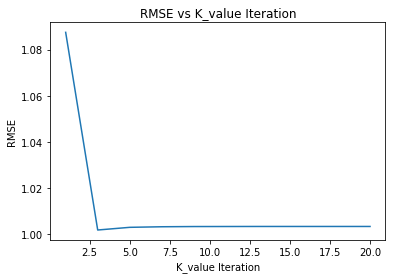

In [213]:
plt.plot(kvalue_list,rmse_list)
plt.title('RMSE vs K_value Iteration')
plt.xlabel('K_value Iteration')
plt.ylabel('RMSE')

### Matrix Factorization Model

In [50]:
# Example Run: ALS with random chosen parameters
als = ALS(maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als_model = als.fit(train)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
predicted_ratings_als = als_model.transform(val)
predicted_ratings_als = \
    predicted_ratings_als.withColumn('rating', predicted_ratings_als.prediction).drop('prediction')

In [51]:
rmse_als, mae_als, r2_als, explainedvar_als= \
regression_metric(val, predicted_ratings_als)

RMSE = 0.895115118791
MAE = 0.670517276087
R-squared = 0.256609993978
Explained Variance = 0.691040291716


In [53]:
# Re-run the cell when there is an error
averageprecision_als, precision_als, ndcg_als = \
ranking_metric(val, predicted_ratings_als)

mean Average Precision = 0.529251556357
Precision at k = 0.496996445356
NDCG at k = 0.702288725705


#### Hyperparameter Tuning

In [0]:
"""
CAUTION: THIS CELL TAKES LONG TO RUN
Hyperparameter tuning using one validation set. 
"""
def hyperparameter_tuning(grid):
    param_vals = []
    for key,v in grid.items():
        param_vals.append(v)
      
    final_results = dict()
    for i in itertools.product(*param_vals):

        inputs = dict()
        for j,(key,v) in enumerate(grid.items()):
            inputs[key] = i[j]
        inputs['userCol'] ='userId'
        inputs['itemCol'] = 'movieId'
        inputs['ratingCol'] = 'rating'
        inputs['coldStartStrategy'] = 'drop'
        als = ALS(**inputs)
        model = als.fit(train)
        predictions = model.transform(val)
        predictions = predictions.withColumn('rating', predictions.prediction).drop('prediction')
        cv_rmse, cv_mae, cv_rw, cv_exp_var = \
        regression_metric(val, predictions)
        final_results[i] = {'rmse': cv_rmse}
  
  return final_results

In [0]:
grid = {'maxIter': np.linspace(5,25,5).astype(int), 'rank':[20], 'regParam': [0.1]} 

In [33]:
maxIter_results = hyperparameter_tuning(grid)

RMSE = 2.5512730180041228
MAE = 2.213876003799786
R-squared = -4.465322576591554
Explained Variance = 5.43121749648
RMSE = 1.5234581941717709
MAE = 1.2630564577546632
R-squared = -0.9487808812065732
Explained Variance = 1.5625985611131634
RMSE = 1.330618443914953
MAE = 1.0863544675063626
R-squared = -0.48665092726272463
Explained Variance = 1.1167178494000325
RMSE = 1.266634117531682
MAE = 1.0239932933451168
R-squared = -0.3471138206115383
Explained Variance = 0.9931431060528412
RMSE = 1.238508152369095
MAE = 0.9953985695147448
R-squared = -0.2879519690294159
Explained Variance = 0.9425591322578566


In [0]:
def process_results(results, index):
    param_list = []
    rmse_list = []
    for k,v in results.items():
        param_list.append(k[index])
        rmse_list.append(v['rmse'])
    return param_list, rmse_list

In [0]:
max_iter_list, rmse_iter_list = process_results(maxIter_results,0)

Text(0, 0.5, 'RMSE')

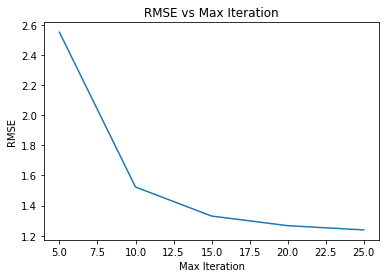

In [45]:
plt.plot(max_iter_list,rmse_iter_list)
plt.title('RMSE vs Max Iteration')
plt.xlabel('Max Iteration')
plt.ylabel('RMSE')

In [0]:
grid = {'maxIter': [25], 'rank':np.linspace(10,50,5).astype(int), 'regParam': [0.1]}

In [50]:
rank_results = hyperparameter_tuning(grid)

RMSE = 1.2759736359598604
MAE = 1.013234652918884
R-squared = -0.36705293103401915
Explained Variance = 1.0499906871826763
RMSE = 1.238508152369095
MAE = 0.9953985695147448
R-squared = -0.2879519690294159
Explained Variance = 0.9425591322578566
RMSE = 1.2257168419900661
MAE = 0.9891615326487391
R-squared = -0.2614854196254093
Explained Variance = 0.9156503683033267
RMSE = 1.2188498419628548
MAE = 0.9841657307992777
R-squared = -0.24739023185084763
Explained Variance = 0.903184919545412
RMSE = 1.2169645744548008
MAE = 0.9832248178215358
R-squared = -0.24353439093656126
Explained Variance = 0.885860700933043


Text(0, 0.5, 'RMSE')

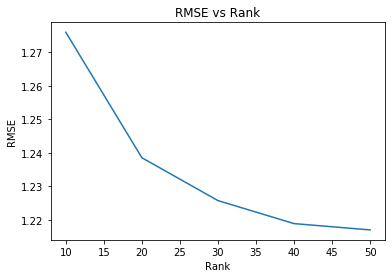

In [64]:
rank_list, rmse_rank_list = process_results(rank_results,1)
plt.plot(rank_list,rmse_rank_list)
plt.title('RMSE vs Rank')
plt.xlabel('Rank')
plt.ylabel('RMSE')

In [0]:
# Example Run: ALS with random chosen parameters
als = ALS(maxIter=25, regParam=0.01, rank = 100, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als_model = als.fit(train)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
predicted_ratings_als = als_model.transform(val)
predicted_ratings_als = \
    predicted_ratings_als.withColumn('rating', predicted_ratings_als.prediction).drop('prediction')

In [0]:
grid = {'maxIter': [25], 'rank':[50], 'regParam':np.linspace(.1,.5,5)}

In [75]:
regularization_results = hyperparameter_tuning(grid)

RMSE = 1.2169645744548008
MAE = 0.9832248178215358
R-squared = -0.24353439093656126
Explained Variance = 0.885860700933043
RMSE = 1.1640439288424664
MAE = 0.9305057156356168
R-squared = -0.13773382073215124
Explained Variance = 0.7953085838150661
RMSE = 1.1406048570880876
MAE = 0.9070658746782891
R-squared = -0.09237653186393868
Explained Variance = 0.7549266842809625
RMSE = 1.128702033107405
MAE = 0.8947194598618473
R-squared = -0.0696964211022415
Explained Variance = 0.7267663496817095
RMSE = 1.1354100241163725
MAE = 0.9032929411767453
R-squared = -0.0824488325779884
Explained Variance = 0.7174145455959837


Text(0, 0.5, 'RMSE')

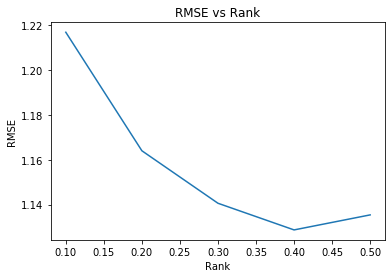

In [77]:
reg_list, rmse_reg_list = process_results(regularization_results,2)
plt.plot(reg_list,rmse_reg_list)
plt.title('RMSE vs Rank')
plt.xlabel('Rank')
plt.ylabel('RMSE')

## Performance Comparison on Test Set

In [85]:
# combine train and cv


# run three models on traincv and evaluate on test


# Create visualization of metrics change